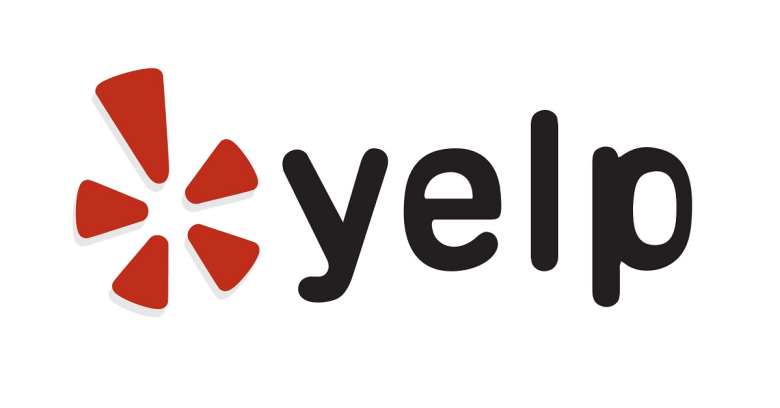

# Yelp Review Data - NLP Project

I will use the Yelp review database located in: (https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. The "useful" and "funny" columns are similar to the "cool" column.

## Imports
 **Import the usual suspects. :) **

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## The Data

**Read the yelp.csv file and set it as a dataframe called yelp.**

In [3]:
yelp=pd.read_csv('yelp.csv')

** Check the head, info , and describe methods on yelp.**

In [4]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


Let's start with some exploratory data analysis

In [5]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


For visualization purposes, a 'text_length' column can be created that shows the lenght of each text.

In [6]:
yelp['text_length']=yelp['text'].apply(len)

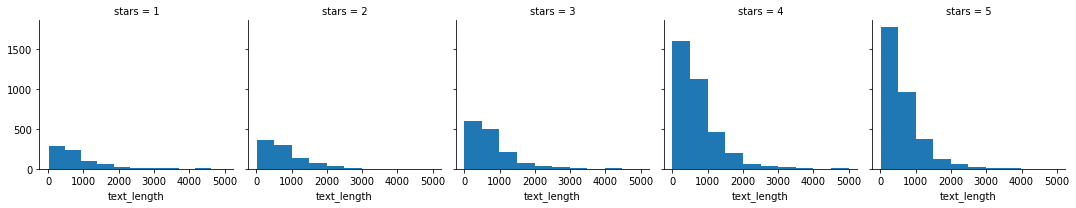

In [7]:
g=sns.FacetGrid(data=yelp, col='stars')
g=g.map(plt.hist, 'text_length')

The longest texts tend to be rated 4 or 5 stars. 

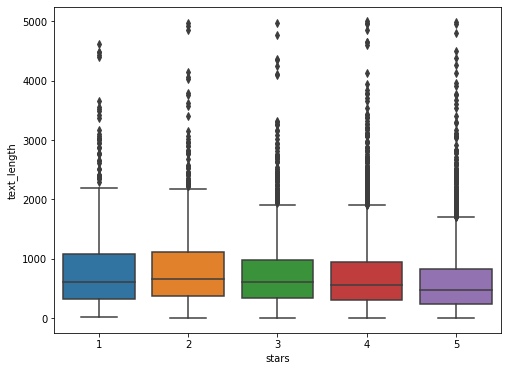

In [189]:
plt.figure(figsize=(8,6))
sns.boxplot(x='stars', y='text_length', data=yelp)

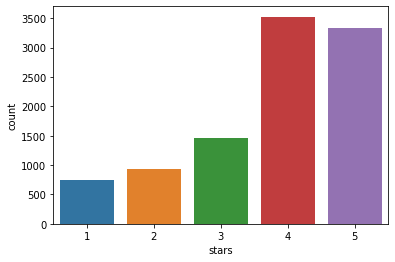

In [9]:
sns.countplot(yelp['stars'])

In this count plot we can see that this dataset has more positive ratings than negative (unbalanced classes).

In [10]:
yelp.groupby('stars').mean()

,cool,useful,funny,text_length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


Now let's check the correlation between the columns in the dataframe.

In [11]:
df=yelp.groupby('stars').mean().corr()
df

,cool,useful,funny,text_length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text_length,-0.857664,0.699881,0.843461,1.000000


A clustermap can show this correlation better.

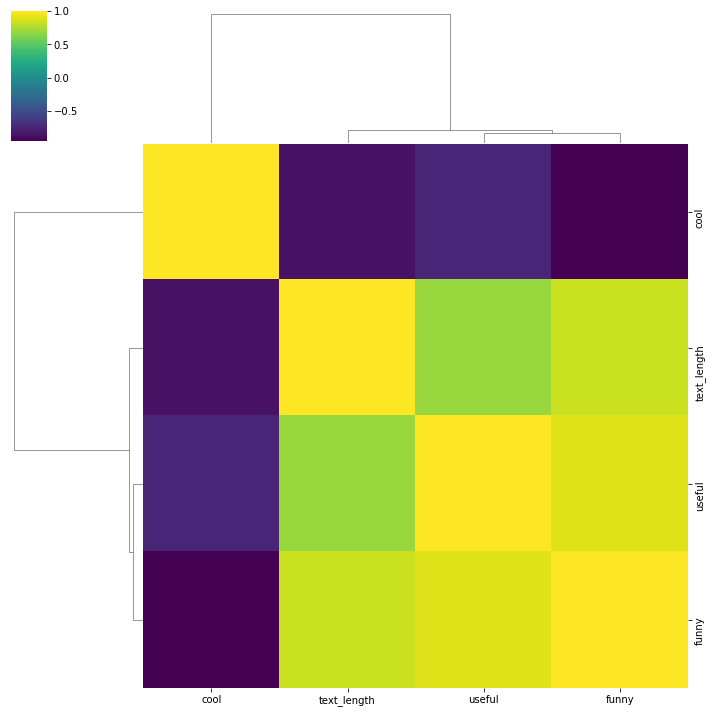

In [188]:
sns.clustermap(df, cmap='viridis')

There is high correlation between the text length and the useful column. There is also a high correlation between the funny and useful columns. 

## NLP Classification

In [13]:
yelp_class=pd.DataFrame(yelp)
yelp_class.head(3)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text_length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,76


First q new column must be created with the sentiment of each review according to stars. If 1 or 2 was given, then negative. If 3 was given then neutral. If 4 or 5, then positive.

In [163]:
def sentiment(parameter):
    if parameter==1 or parameter==2:
        return 'negative'
    elif parameter==3:
        return 'neutral'
    elif parameter==4 or parameter==5:
        return 'positive'
yelp['sentiment']=yelp['stars'].apply(sentiment)
yelp['sentiment'].value_counts()

positive    6863
negative    1676
neutral     1461
Name: sentiment, dtype: int64

The text column needs a transformation. First the punctuation and the stop words must be removed. Then the result must be lemmatized.

In [82]:
from nltk import pos_tag
from nltk.corpus import wordnet
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            pos = nltk.pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(word.lower())
    return " ".join(final_text)

lemmatize_words('I am learning Data Science')

'learn data science'

In [85]:
Lem_text=yelp['text'].apply(lemmatize_words)
Lem_text

0       wife take birthday breakfast excellent. weathe...
1       idea people give bad review place. go show you...
2       love gyro plate. rice good also dig candy sele...
3       rosie, dakota, love chaparral dog park!!! conv...
4       general manager scott petello good egg!!! go d...
                              ...                        
9995    first visit...had lunch today use groupon. ord...
9996    call house deliciousness! could go item, item,...
9997    recently visit olive ivy business last week, 3...
9998    nephew move scottsdale recently bunch friend b...
9999    4-5 locations.. 4.5 star average.. think arizo...
Name: text, Length: 10000, dtype: object

Now we can split the data

In [159]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(Lem_text, yelp['sentiment'], test_size=0.3, random_state=101)

Now we can convert our data into a sparse matrix with CountVectorizer 

In [89]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()
bow_train=cv.fit_transform(X_train)
bow_test=cv.transform(X_test)

In [90]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
tfidf_train=tfidf_transformer.fit_transform(bow_train)
tfidf_test=tfidf_transformer.transform(bow_test)

Now its time to fit the data to a classifier model

**Support Vector Machine**

In [144]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
             {'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'degree:[1,2,3,4]},
             {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = SVC(),
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10, #k fold cross validation - number of folds 
                           n_jobs = -1,
                          verbose=10) 
grid_search = grid_search.fit(tfidf_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 22

Best Accuracy: 78.17 %
Best Parameters: {'C': 1, 'kernel': 'linear'}


In [165]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=10)

model.fit(tfidf_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [166]:
predict_tfidf=model.predict(tfidf_test)

In [169]:
print('results for tf-idf')
print(classification_report(predict_tfidf,y_test))
cm = confusion_matrix(predict_tfidf, y_test)
cm

tfidf_score=accuracy_score(y_test,predict_tfidf)
print("lr_tfidf_score :",tfidf_score)

results for tf-idf
              precision    recall  f1-score   support

    negative       0.62      0.61      0.62       507
     neutral       0.33      0.36      0.35       413
    positive       0.86      0.85      0.85      2080

    accuracy                           0.74      3000
   macro avg       0.60      0.60      0.60      3000
weighted avg       0.74      0.74      0.74      3000

lr_tfidf_score : 0.7406666666666667


**Logistic Regression**

In [170]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=500)

lr_tfidf=lr.fit(tfidf_train, y_train)

In [171]:
predict_tfidf=lr_tfidf.predict(tfidf_test)

In [172]:
print('results for tf-idf applied')
print(classification_report(predict_tfidf,y_test))
cm = confusion_matrix(predict_tfidf, y_test)
cm

tfidf_score=accuracy_score(y_test,predict_tfidf)
print("lr_tfidf_score :",tfidf_score)

results for tf-idf applied
              precision    recall  f1-score   support

    negative       0.52      0.80      0.63       320
     neutral       0.18      0.55      0.27       146
    positive       0.97      0.79      0.87      2534

    accuracy                           0.78      3000
   macro avg       0.56      0.71      0.59      3000
weighted avg       0.89      0.78      0.82      3000

lr_tfidf_score : 0.7823333333333333


**Naive Bayes**

In [173]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB()

nb_tfidf=nb.fit(tfidf_train, y_train)

In [176]:
predict_tfidf=nb_tfidf.predict(tfidf_test)

In [178]:
print('results for tf-idf applied')
print(classification_report(predict_tfidf,y_test))
cm = confusion_matrix(predict_tfidf, y_test)
cm

tfidf_score=accuracy_score(y_test,predict_tfidf)
print("lr_tfidf_score :",tfidf_score)

results for tf-idf applied
              precision    recall  f1-score   support

    negative       0.00      1.00      0.00         1
     neutral       0.00      0.00      0.00         0
    positive       1.00      0.69      0.82      2999

    accuracy                           0.69      3000
   macro avg       0.33      0.56      0.27      3000
weighted avg       1.00      0.69      0.82      3000

lr_tfidf_score : 0.6883333333333334


**K nearest neighbors**

In [183]:
from sklearn.neighbors import KNeighborsClassifier
kn=KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
kn_tfidf=kn.fit(tfidf_train, y_train)

In [184]:
predict_tfidf=kn_tfidf.predict(tfidf_test)

In [185]:
print('results for tf-idf applied')
print(classification_report(predict_tfidf,y_test))
cm = confusion_matrix(predict_tfidf, y_test)
cm

#Accuracy score for tfidf features
tfidf_score=accuracy_score(y_test,predict_tfidf)
print("lr_tfidf_score :",tfidf_score)

results for tf-idf applied
              precision    recall  f1-score   support

    negative       0.34      0.50      0.40       333
     neutral       0.13      0.26      0.17       221
    positive       0.89      0.75      0.81      2446

    accuracy                           0.68      3000
   macro avg       0.45      0.50      0.46      3000
weighted avg       0.77      0.68      0.72      3000

lr_tfidf_score : 0.6846666666666666


## Logistic regression its our best classifier with an accuracy of 78%